## Prepare for Data

In [1]:
import string

language_words = {}
languages = []
n_languages = 0

ascii_letters = string.ascii_letters
n_ascii_letters = len(ascii_letters)

In [2]:
import unicodedata

def unicode_2_ascii(unicode_string):
    ascii_string = ''
    
    for char in unicodedata.normalize("NFD", unicode_string):
        if char in ascii_letters:
            ascii_string += char
            
    return ascii_string

In [3]:
def collect_words(txt):
    with open(txt) as f:
        txt_data = f.read()

    # Places words into a list by splitting space.
    words = txt_data.split()
    # Unicode -> ascii.
    words = [unicode_2_ascii(word) for word in words]
    # Removes duplicates.
    words = list(set(words))
    # Removes empty str.
    try:
        words.remove("")
    except:
        pass
    
    return words

In [4]:
import glob
import os

for txt in glob.glob("data_/*.txt"):
    language = os.path.splitext(os.path.basename(txt))[0]
    words = collect_words(txt)
    
    language_words[language] = words
    
languages = list(language_words.keys())
n_languages = len(languages)

## Build a Model

In [5]:
n_hidden = 128

In [6]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
    
    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), dim=1)
        
        hidden = self.i2h(combined)
        
        output = self.i2o(combined)
        output = nn.LogSoftmax(dim=1)(output)  # log softmax
        
        return output, hidden
    
    def hidden_init(self):
        return torch.zeros(1, self.hidden_size)

In [7]:
rnn = RNN(n_ascii_letters, n_hidden, n_languages)

## Loss Function

In [8]:
loss_func = nn.NLLLoss()

## Optimizer

In [9]:
import torch.optim as optim

optimizer = optim.SGD(rnn.parameters(), lr=0.005)

## Train the Model

In [10]:
n_train_iteration = 100_000

n_display = 5_000
n_plot = 1_000
losses = []

In [11]:
import random

def random_choose(list_):
    random_idx = random.randint(0, len(list_) - 1)
    return list_[random_idx]

In [12]:
def language_2_tensor(language):
    return torch.tensor([languages.index(language)], dtype=torch.long)

In [13]:
def word_2_tensor(word):    
    word_tensor = torch.zeros(len(word), 1, n_ascii_letters)
    for i in range(len(word)):
        char = word[i]
        word_tensor[i][0][ascii_letters.index(char)] = 1
    
    return word_tensor

In [14]:
def random_example():
    language = random_choose(languages)
    word = random_choose(language_words[language])

    language_tensor = language_2_tensor(language)
    word_tensor = word_2_tensor(word)

    return language_tensor, word_tensor

In [15]:
def train(language, word):
    hidden = rnn.hidden_init()
    
    rnn.zero_grad()  # remember
    
    for char in word:
        # Forward.
        output, hidden = rnn(char, hidden)
        
    loss = loss_func(output, language)  # outside the range

    # Backward.
    loss.backward()  # outside the range

    # Updates params.
    optimizer.step()  # outside the range
    
    return output, loss

In [16]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    plt.plot(losses)
    plt.show()

iteration:   5000 (  5%) loss: 2.449658
iteration:  10000 ( 10%) loss: 2.128094
iteration:  15000 ( 15%) loss: 0.497798
iteration:  20000 ( 20%) loss: 1.636408
iteration:  25000 ( 25%) loss: 1.956110
iteration:  30000 ( 30%) loss: 1.720672
iteration:  35000 ( 35%) loss: 0.605064
iteration:  40000 ( 40%) loss: 1.932340
iteration:  45000 ( 45%) loss: 2.648237
iteration:  50000 ( 50%) loss: 0.674706
iteration:  55000 ( 55%) loss: 0.107322
iteration:  60000 ( 60%) loss: 0.151444
iteration:  65000 ( 65%) loss: 3.210803
iteration:  70000 ( 70%) loss: 1.039506
iteration:  75000 ( 75%) loss: 0.204758
iteration:  80000 ( 80%) loss: 2.083888
iteration:  85000 ( 85%) loss: 0.762055
iteration:  90000 ( 90%) loss: 0.772244
iteration:  95000 ( 95%) loss: 0.266486
iteration: 100000 (100%) loss: 0.833019


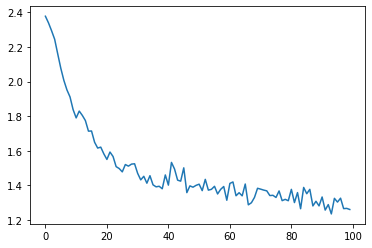

In [17]:
running_loss = 0

for iteration in range(1, n_train_iteration + 1):  # counts from 1 may be better
    # Gets an example.
    language, word = random_example()

    # Training.
    output, loss = train(language, word)

    # Tracks the training process.
    if iteration % n_display == 0:
        print(f"iteration: {iteration:>6} ({iteration / n_train_iteration:>4.0%})", end=" ")
        print(f"loss: {loss:.6f}")
        
    running_loss += loss
    if iteration % n_plot == 0:
        losses.append(running_loss / n_plot)
        running_loss = 0
        
plot_losses(losses)

## Test the Model

In [18]:
n_test_iteration = 10_000

conf_matrix = torch.zeros(n_languages, n_languages)

In [19]:
def test(language, word):
    hidden = rnn.hidden_init()
    
    for char in word:
        output, hidden = rnn(char, hidden)
        
    return output

In [20]:
import matplotlib.ticker as ticker

def plot_conf_matrix(conf_matrixmatrixmatrixmatrixmatrixmatrix):
    # Normalization.
    for i in range(n_languages):
        conf_matrix[i] = conf_matrix[i] / conf_matrix[i].sum()
        
    figure = plt.figure()
    axis = figure.add_subplot(111)
        
    # Plots the conf matrix.
    conf_axis = axis.matshow(conf_matrix)
    
    # Plots a color bar.
    figure.colorbar(conf_axis)
    
    # Sets tick labels.
    axis.set_xticklabels([''] + languages, rotation=90)
    axis.set_yticklabels([''] + languages)
    axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
    axis.yaxis.set_major_locator(ticker.MultipleLocator(1))

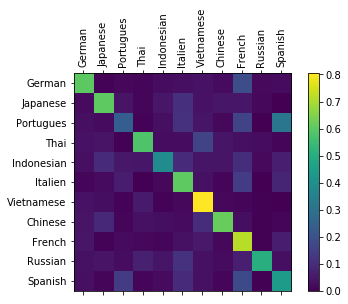

In [21]:
for _ in range(n_test_iteration):
    # Gets an example.
    language, word = random_example()
    
    # Testing.
    output = test(language, word)

    # Tracks the testing process.
    language_idx = language.item()
    prediction_idx = output.max(dim=1).indices
    conf_matrix[language_idx][prediction_idx] += 1
    
plot_conf_matrix(conf_matrix)